# 智能跑鞋商品评论挖掘分析（以天猫商场为例）

在天猫上搜索“智能跑鞋”，共可得500+件商品。爬取了这500多个智能跑鞋的商品信息和用户评论信息，存储在data文件夹内。

其中使用了多线程技术。

In [ ]:
#_*_coding:utf-8_*_
import sys
import os
import re
import time
import random
import codecs
import threading
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import requests
import json

# 工作文件夹
WORKSPACE = r'G:/Data/NetEase/'

# 基本配置
import matplotlib.font_manager as fm
fp_msyh = fm.FontProperties(fname=WORKSPACE+'msyh.ttc')

In [ ]:
# 预处理通用函数
from six.moves.html_parser import HTMLParser
def preprocess(text):
    if type(text)==str:
        text=unicode(text,'utf-8')
    re_h=re.compile('</?\w+[^>]*>')# HTML tags
    result=re_h.sub('',text)
    
    result=HTMLParser().unescape(result) # HTML entities
    return result

In [ ]:
# Stanford CoreNLP（分词、词性标注、句法树、依存关系）
def stanford_nlp(text):
    properties={'pinelineLanguage':'zh','annotators': 'tokenize,ssplit,pos,depparse','outputFormat': 'json'}
    
    r=requests.post('http://localhost:9000',params={'properties': str(properties)},data=text)  
    r_json=json.loads(r.text)
    
    return r_json

## 数据爬取

### 爬取商品信息

In [ ]:
def get_all_product(query,out_path):
    
    base_url = r'https://list.tmall.com/m/search_items.htm?page_size=50&page_no={}&q={}'
    
    r_json = json.loads(requests.get(base_url.format(0,query)).text)
    total_page = r_json['total_page']
    total_num = r_json['total_results']
    print 'Total page: {} Total num: {}'.format(total_page, total_num)

    item_ids = []
    cat_ids = []
    sku_ids = []
    spu_ids = []

    comment_nums = []
    solds = []

    is_promotions = []
    prices = []
    post_fees = []

    seller_ids = []
    seller_locs = []
    shop_names = []

    titles = []

    for page in xrange(total_page):
        url = base_url.format(page,query)

        try:
            r_json = json.loads(requests.get(url).text)
        except:
            print 'Error!', url
            continue

        for item in r_json['item']:
            item_ids.append(item['item_id'])
            cat_ids.append(item['cat_id'])
            sku_ids.append(item['sku_id'])
            spu_ids.append(item['spu_id'])

            comment_nums.append(item['comment_num'])
            solds.append(item['sold'])

            is_promotions.append(item['is_promotion'])
            prices.append(item['price'])
            post_fees.append(item['post_fee'])

            seller_ids.append(item['seller_id'])
            seller_locs.append(item['seller_loc'])
            shop_names.append(item['shop_name'])

            titles.append(item['title'])

    df_product = pd.DataFrame({'item_id': item_ids, 'cat_id': cat_ids, 'sku_id': sku_ids, 'spu_id': spu_ids, 'comment_num': comment_nums, 'sold': solds,
                               'is_promotion': is_promotions, 'price': prices, 'post_fee': post_fees, 'seller_id': seller_ids, 'seller_loc': seller_locs, 'shop_name': shop_names, 'title': titles}, columns=['item_id', 'cat_id', 'sku_id', 'spu_id', 'comment_num', 'sold', 'is_promotion', 'price', 'post_fee', 'seller_id', 'seller_loc', 'shop_name', 'title'])
    df_product=df_product.drop_duplicates()
#     df_product.to_csv(out_path, encoding='utf-8', index=False)
    print 'Size {}. Saved at {}.'.format(df_product.shape,out_path)
    return df_product

# out_path=WORKSPACE + 'data/product.csv'
# get_all_product('智能跑鞋',out_path)

shoes=['鞋子','鞋子 男','鞋子 女','板鞋','布鞋','皮鞋','帆布鞋','运动鞋','休闲鞋']
shoes_df_list=[]
for s in shoes:
    shoes_df_list.append(get_all_product(s,out_path))
df=pd.concat(shoes_df_list).drop_duplicates()
print df.shape
df.to_csv(WORKSPACE + 'data/product_shoes.csv', encoding='utf-8', index=False)


### 爬取商品评论
order: 1：按时间排序；3：默认排序

append: 0 or 1， 切换追加评论

content: 0 or 1， 是否显示有内容的评论

needFold: 0 or 1， 是否折叠评论

In [ ]:
def crawl_one_item(item_id, seller_id):

    #     item_id=531979715453
    #     seller_id=1770496755

    comment_url = r'https://rate.tmall.com/list_detail_rate.htm?itemId={}&sellerId={}&order=1&currentPage=1&append=0&content=0'.format(
        item_id, seller_id)

    r = requests.get(comment_url)
    r_json = json.loads(r.text[15:])

    page_num = r_json['paginator']['lastPage']
    page_num_fold = json.loads(requests.get(
        r'https://rate.tmall.com/list_detail_rate.htm?itemId={}&sellerId={}&order=1&currentPage=1&append=0&content=0'.format(item_id, seller_id)).text[15:])['paginator']['lastPage']

    rate_dates = []
    auction_skus = []
    tmall_sweet_levels = []
    is_folds = []
    contents = []

    # 翻页
    page = 1
    while page <= page_num:
        comment_url = r'https://rate.tmall.com/list_detail_rate.htm?itemId={}&sellerId={}&order=1&currentPage={}&append=0&content=0&needFold=0'.format(item_id, seller_id,
                                                                                                                                                       page)
        r = requests.get(comment_url)

        try:
            r_json = json.loads(r.text[15:])
        except:
            print 'Warning: ' + comment_url
            sys.stdout.flush()
            continue

        for comment in r_json['rateList']:

            rate_dates.append(comment['rateDate'])
            auction_skus.append(comment['auctionSku'])
            tmall_sweet_levels.append(comment['tamllSweetLevel'])
            is_folds.append(False)
            contents.append(comment['rateContent'])

        page += 1

    # 翻页，被折叠的评论
    page = 1
    while page <= page_num_fold:
        comment_url = r'https://rate.tmall.com/list_detail_rate.htm?itemId={}&sellerId={}&order=1&currentPage={}&append=0&content=0&needFold=1'.format(
            item_id, seller_id, page)
        r = requests.get(comment_url)

        try:
            r_json = json.loads(r.text[15:])
        except:
            print 'Warning: ' + comment_url
            sys.stdout.flush()
            continue

        for comment in r_json['rateList']:
            rate_dates.append(comment['rateDate'])
            auction_skus.append(comment['auctionSku'])
            tmall_sweet_levels.append(comment['tamllSweetLevel'])
            is_folds.append(True)
            contents.append(comment['rateContent'])

        page += 1

    # Save
    df_comment = pd.DataFrame({'rate_date': rate_dates, 'auction_sku': auction_skus, 'tmall_sweet_level': tmall_sweet_levels,
                               'is_fold': is_folds, 'content': contents}, columns=['rate_date', 'auction_sku', 'tmall_sweet_level', 'is_fold', 'content'])
    df_comment.to_csv(WORKSPACE + 'data/comment_shoes/' +
                      str(item_id) + '.csv', encoding='utf-8', index=False)
    print '-> Finished item_id: {}'.format(item_id)

# Test
# crawl_one_item(531818703657, 363607599)

In [ ]:
def crawl_part(item_ids,seller_ids):
    assert len(item_ids)==len(seller_ids)
    
    num=len(item_ids)
    idx=0
    while idx < num:
        try:
            print 'Crawling: {}'.format(item_ids[idx])
            crawl_one_item(item_ids[idx],seller_ids[idx])
        except:
            continue
        idx+=1
                       
def get_all_comment(df_product):          
    item_ids=[]
    seller_ids=[]
    for ids,row in df_product.sort_values(by='item_id').iterrows():
        item_ids.append(row['item_id'])
        seller_ids.append(row['seller_id'])

    thread_num=20 # The final thread num will plus one when there is remainder
    total_num=len(item_ids)
    thread_size=total_num/thread_num
    print 'Total product items: {}'.format(total_num)

    threads=[]
    for idx in xrange(thread_num):
        start=idx*thread_size
        end=(idx+1)*thread_size
        t=threading.Thread(target=crawl_part,args=(item_ids[start:end],seller_ids[start:end]))
        threads.append(t)

    remainder=total_num%thread_num
    if not remainder==0:
        t=threading.Thread(target=crawl_part,args=(item_ids[-remainder:],seller_ids[-remainder:]))
        threads.append(t)

    for t in threads:
        t.start()

    happy_ending=False

    while not happy_ending:
        active_cout=0
        for t in threads:
            if t.is_alive():
                active_cout+=1   
        if active_cout<=0:
            happy_ending=True
        else:
            print '{} threads still running...'.format(active_cout)        
        time.sleep(5)

    print 'Happy ending!'


df_product=pd.read_csv(WORKSPACE +'data/product_shoes.csv')         
get_all_comment(df_product)

### 爬取正负面评论

In [ ]:
def get_sentiment_comment(item_id, seller_id):
    base_tag_url = r'https://rate.tmall.com/listTagClouds.htm?itemId=531979715453&isAll=true'
    r = requests.get(base_tag_url)
    r = json.loads(r.text[9:])

    pos_tag_ids = []
    neg_tag_ids = []
    for tag_cloud in r['tagClouds']:
        if tag_cloud['posi']:
            pos_tag_ids.append(tag_cloud['id'])
        else:
            neg_tag_ids.append(tag_cloud['id'])

    pos_tag_ids = []

    f_pos = codecs.open(WORKSPACE + 'comment.pos', 'a', encoding='utf-8')
    f_neg = codecs.open(WORKSPACE + 'comment.neg', 'a', encoding='utf-8')

    for tag_id in pos_tag_ids:
        f_pos.writelines('\n'.join(get_one_sentiment_comment(
            item_id, seller_id, tag_id, 1)))
    for tag_id in neg_tag_ids:
        f_neg.writelines('\n'.join(get_one_sentiment_comment(
            item_id, seller_id, tag_id, -1)))

    f_pos.close()
    f_neg.close()


def get_one_sentiment_comment(item_id, seller_id, tag_id, posi):
    print 'Getting tag id {} posi {}...'.format(tag_id, posi)
#     comment_url = r'https://rate.tmall.com/list_detail_rate.htm?itemId={}&sellerId={}&order=1&currentPage=1&append=0&content=0&tagId={}&posi={}'.format(
#         item_id, seller_id, tag_id, posi)

#     r = requests.get(comment_url)
#     r_json = json.loads(r.text[15:])

    contents = []

    # 翻页
    page = 1
    page_num = 1
    while page <= page_num:
        comment_url = r'https://rate.tmall.com/list_detail_rate.htm?itemId={}&sellerId={}&order=1&currentPage={}&append=0&content=0&tagId={}&posi={}'.format(
            item_id, seller_id, page, tag_id, posi)

        try:
            r = requests.get(comment_url)
            r_json = json.loads(r.text[15:])
        except:
            continue

        page_num = r_json['paginator']['lastPage']

        for comment in r_json['rateList']:
            contents.append(preprocess(comment['rateContent']))

        page += 1
    for content in contents:
        print type(content), content
    return contents


# get_sentiment_comment(531979715453, 1770496755)
# get_sentiment_comment(531823943112,1770496755)
# get_sentiment_comment(521310943964,1681391303)
get_sentiment_comment(529060341366,1735917344)

In [ ]:
def test_proxy():
    
    proxies = {'http': 'http://127.0.0.1:8087',
               'https': 'https://59.44.16.8:80'}
#     r = requests.get('https://www.baidu.com', proxies=proxies)
#     r = requests.get('http://www.qq.com', proxies=proxies)
    r = requests.get('https://rate.tmall.com/list_detail_rate.htm?itemId=531979715453&sellerId=1770496755&order=3&currentPage=1&append=0&content=1', proxies=proxies)
    print r, r.text


# test_proxy()

## 描述性统计

In [5]:
def get_comment_df():
    comments_dir=r'G:/Data/NetEase/data/comments/'
    comment_list=[]
    for f in os.listdir(comments_dir):
        comment_file=os.path.join(comments_dir,f)
        df=pd.read_csv(comment_file)
        if df.empty: continue
        df['item_id']=f[:-4]
        comment_list.append(df)

    return pd.concat(comment_list)

df_comment=get_comment_df()

### 一天评论数量变化趋势

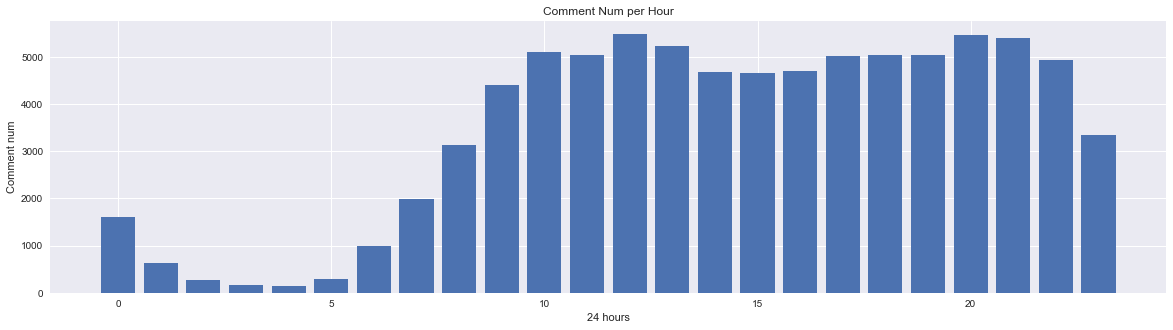

In [6]:
df_comment['hour']=df_comment['rate_date'].map(lambda x:str(x)[-8:-6])

hour_goup=df_comment.groupby('hour').count()['item_id']

plt.figure(figsize=(20,5))
plt.bar(np.arange(24),hour_goup)
plt.title('Comment Num per Hour')
plt.xlabel('24 hours')
plt.ylabel('Comment num')
plt.show()

# product_path=r"G:\Data\NetEase\data\comments\520363612568.csv"
# df_comment=pd.read_csv(product_path)
# df_comment['rate_date']=pd.to_datetime(df_comment['rate_date'])

# # df_comment.head()

# df_comment.resample('M',on='rate_date').count()


从图中可以看出用户评论的时间主要是在白天，晚上23点之后评论量开始急速下降。
评论有两个高峰时段，分别是中午12点和晚上20点，这与日常人们的下班闲暇时间吻合。如果App需要推送商品推荐信息，则选择这两个时间段可能是一个很好的选择。

### 用户鞋码分布

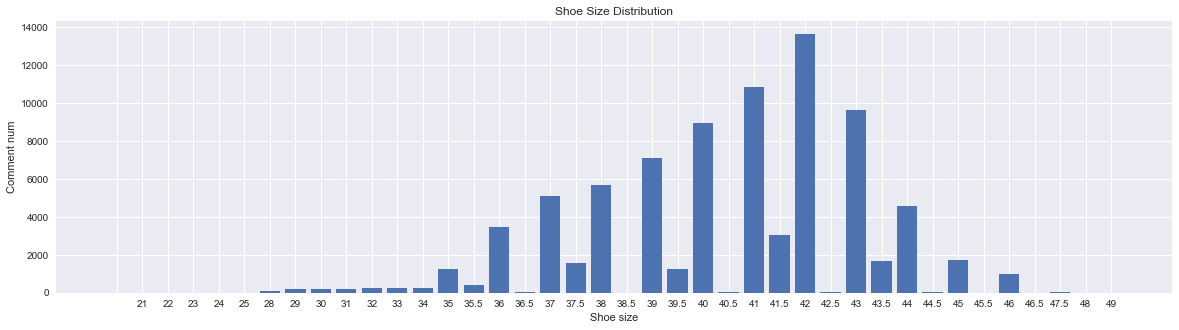

In [7]:
def extract_shoe_size(text):
    text = preprocess(text)
    
    # 无鞋码信息
    if re.search(ur'\d{2}',text)==None:
        return ''
    
    try:
        result=text.split(';')[1].split(':')[1]
        result=re.sub('/.*','',result)
        result=re.sub(u'码','',result)
        result=re.sub(ur'[\[\(（].*[\]\)）]','',result)
        return result
    except:
        r = re.findall('\d{2}', text)
        result = ''
        if len(r) > 0:
            result = r[0]
        return result

df_comment['shoe_size']=df_comment['auction_sku'].map(extract_shoe_size)
shoe_size_group=df_comment.groupby('shoe_size').count()['item_id']

x=np.arange(len(shoe_size_group))

plt.figure(figsize=(20,5))
plt.bar(x,shoe_size_group)
plt.title('Shoe Size Distribution')
plt.xlabel('Shoe size')
plt.ylabel('Comment num')
plt.xticks(x,shoe_size_group.index)

plt.show()

从鞋码分布图来看，排行前三的是41码，42码和43码。

### 用户颜色偏好分析

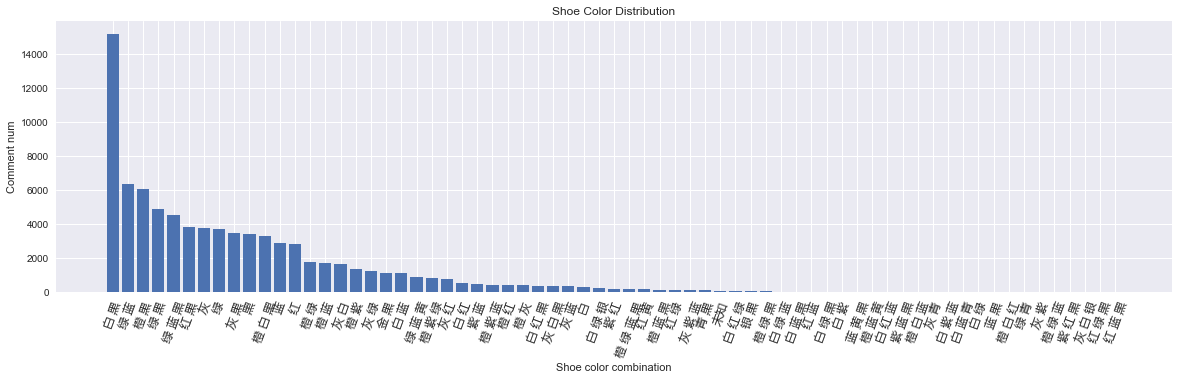

In [8]:
def extract_shoe_color(text):
    text = preprocess(text)
    result=re.findall(ur'[黑白赤橙黄绿青蓝紫红灰金银铜棕褐]',text)
    result=list(set(result))
    result.sort()
    if len(result)==0:
        result=[u'未知']
    return ' '.join(result)
# for text in df_comment['auction_sku']:
#     print text
#     print extract_shoe_color(text)

df_comment['shoe_color']=df_comment['auction_sku'].map(extract_shoe_color)
shoe_color_group=df_comment.groupby('shoe_color').count()['item_id'].sort_values(ascending=False)


x=np.arange(len(shoe_color_group))

plt.figure(figsize=(20,5))
plt.bar(x,shoe_color_group)
plt.title('Shoe Color Distribution')
plt.xlabel('Shoe color combination')
plt.ylabel('Comment num')
plt.xticks(x,shoe_color_group.index,rotation=70,fontproperties=fp_msyh)

plt.show()

从跑鞋颜色分布图来看，“黑 白”颜色组合的跑鞋成为最畅销的产品，且远远超过其它的颜色组合。其中“黑”色在销量排名前几位的颜色组合中几乎都可以看到它的影子，因此“黑”色是跑鞋设计中需要重点考虑的颜色。

另外，蓝色、绿色和橙色也具有一定的用户群。

## 用户印象

In [9]:
import codecs
hownet_pos_opinion_words = [line.strip() for line in codecs.open(
    WORKSPACE + "HowNetPosOpinionWords.txt", encoding='utf-8').readlines()]
hownet_neg_opinion_words = [line.strip() for line in codecs.open(
    WORKSPACE + "HowNetNegOpinionWords.txt", encoding='utf-8').readlines()]


def compute_unit_polarity(unit):
    p = 0
    if unit['opinion'] in hownet_pos_opinion_words:
        p = 1

    if unit['opinion'] in hownet_pos_opinion_words and unit['negPosition'] == -1:
        p = -1

    if unit['opinion'] in hownet_neg_opinion_words:
        p = -1

    if unit['opinion'] in hownet_neg_opinion_words and unit['negPosition'] == -1:
        p = 1

    return p

In [10]:
from wordcloud import WordCloud
from PIL import Image

def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

# 绘制标签云
def wordcloud(freqs_pos,freqs_neg):
    freqs_pos=dict(freqs_pos)
    freqs_neg=dict(freqs_neg)
    
#     freqs_pos=dict([(u'速度毋庸置疑',5),(u'数据准确',5),(u'脚掌大',5),(u'脚后跟疼',5),(u'老公喜欢',5),(u'尺寸合适',6),(u'软硬适中',5),(u'穿着舒服',5),(u'小段同学',4),(u'曲小花',3),(u'中文分词',2),(u'样例',1)])
#     freqs_neg=dict([(u'速度毋庸置疑',5),(u'数据准确',5),(u'脚掌大',5),(u'脚后跟疼',5),(u'老公喜欢',5),(u'尺寸合适',6),(u'软硬适中',5),(u'穿着舒服',5),(u'小段同学',4),(u'曲小花',3),(u'中文分词',2),(u'样例',1)])
    
    shoe_mask = np.array(Image.open(WORKSPACE+"mask.jpg"))
    
    wc_pos=WordCloud(font_path=WORKSPACE+"msyh.ttc",background_color="white",mask=shoe_mask)
    wc_pos.generate_from_frequencies(freqs_pos,max_font_size=90)
    
    wc_neg=WordCloud(font_path=WORKSPACE+"msyh.ttc",background_color="white",mask=shoe_mask)
    wc_neg.generate_from_frequencies(freqs_neg,max_font_size=90)
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.imshow(wc_pos)
    plt.axis("off")
    
    plt.subplot(1,2,2)
    plt.imshow(wc_neg.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")    
    plt.axis("off")
    
    plt.show()

Processing sentence 3959/3960...Positive:  2508 Negative:  368


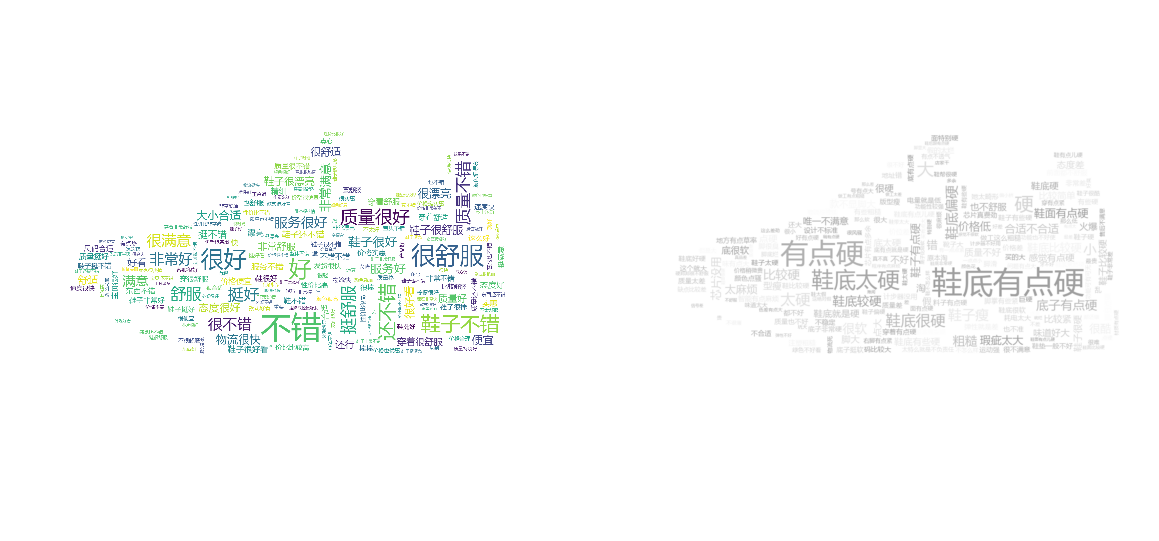

In [11]:
from collections import Counter

opinion_units=[]
def extract(words,tags,deps):
    unit={'target':0,'opinion':0,'degree':0,'neg':0,'negPosition':0}
    
    # Rule 1
    for idx,tag in enumerate(tags):
        unit=unit.fromkeys(unit,0)
        if tag=='VA':
            unit['opinion']=words[idx]
            for dep in deps:
                # 评价对象
                if dep[1]==idx+1 and dep[0]=='nsubj':
                    unit['target']=words[dep[2]-1]
                    
                # 程度副词
                if dep[1]==idx+1 and dep[0]=='advmod':
                    unit['degree']=words[dep[2]-1]
                
                # 否定词
                if dep[1]==idx+1 and dep[0]=='neg':
                    unit['neg']=words[dep[2]-1]
                    if dep[1]==dep[2]+1:
                        unit['negPosition']=-1
                    else:
                        unit['negPosition']=-2
            if unit['target']==0: unit['target']='Implicit'
            opinion_units.append(unit)
          
    # Rule 2
    for dep in deps:
        unit=unit.fromkeys(unit,0)
        if dep[0]=='nsubj':
            if tags[dep[1]-1]=='VV' and tags[dep[2]-1]=='NN':
                unit['target']=words[dep[2]-1]
                unit['opinion']=words[dep[1]-1]
                opinion_units.append(unit)

                
# product_path=r"G:\Data\NetEase\test.csv"
product_path=WORKSPACE+r"data\comments\531979715453.csv"
df_comment=pd.read_csv(product_path)

num=df_comment.shape[0]

for comment_id,comment in enumerate(df_comment['content']):
    
#     if comment_id==100:
#         break
        
    sys.stdout.write('\r'+'Processing sentence {}/{}...'.format(comment_id,num))
    sys.stdout.flush()

    # text = ('非常舒服轻便。运动芯片也很赞。智能运动鞋超级酷。')
    text=preprocess(comment).encode("utf-8")

    properties={'pinelineLanguage':'zh','annotators': 'tokenize,ssplit,pos,depparse','outputFormat': 'json'}
    
    r=requests.post('http://localhost:9000',params={'properties': str(properties)},data=text)  
    r_json=json.loads(r.text)

    for sentence in r_json['sentences']:
        words=[]
        tags=[]
        deps=[]

        for token in sentence['tokens']:
    #         print token['word'],token['pos']
            words.append(token['word'])
            tags.append(token['pos'])
        for dep in sentence['basicDependencies']:
    #         print (dep['dep'],dep['governor'],dep['dependent'])
            deps.append((dep['dep'],dep['governor'],dep['dependent']))

        extract(words,tags,deps)

# for p in opinion_units:
#     print p['target'],p['opinion'],p['degree'],p['neg'],p['negPosition']

# 计算情感单元情感倾向性    
pos_opinion_units=[]
neg_opinion_units=[]
for unit in opinion_units:
    p=compute_unit_polarity(unit)
    if p==1:
        pos_opinion_units.append(unit)
    elif p==-1:
        neg_opinion_units.append(unit)
    else:
        pass
#         print 'Cant find polarity!',unit['target'],unit['opinion'],unit['degree'],unit['neg'],unit['negPosition']

print 'Positive: ',len(pos_opinion_units),'Negative: ',len(neg_opinion_units)

# 统计频率
def units_to_freqs(opinion_units):
    opinion_dict={}
    for unit in opinion_units:
        
        to_append=''
        if unit['degree']==0: unit['degree']=''
        
        if not unit['neg']==0:
            if unit['negPosition']==-1:
#                 print unit['degree'],unit['neg'],unit['opinion']
                to_append=unit['degree']+unit['neg']+unit['opinion']
            elif unit['negPosition']==-2:
                to_append=unit['neg']+unit['degree']+unit['opinion']
        else:
            to_append=unit['degree']+unit['opinion']
        
        if opinion_dict.has_key(unit['target']):        
            opinion_dict[unit['target']].append(to_append)
        else:           
            opinion_dict[unit['target']]=[to_append]

    opinion_dict=dict([(key,dict(Counter(value)))for key,value in opinion_dict.items()])  
    
    # 处理隐式评价对象
    opinion_dict[' ']=opinion_dict.pop('Implicit')

    return sorted([(t+o,v) for t,value in opinion_dict.items() for o,v in value.items()],key=lambda x:x[1],reverse=True)    
        
pos_impression_freqs=units_to_freqs(pos_opinion_units)
neg_impression_freqs=units_to_freqs(neg_opinion_units)

wordcloud(pos_impression_freqs,neg_impression_freqs)

Note: 这里需要Stanford CoreNLP 3.7.0库的支持，下载后在文件夹内运行命令：

`java -Xmx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -serverProperties StanfordCoreNLP-chinese.properties -port 9000 -timeout 15000`

我们这里使用商品531979715453（https://detail.tmall.com/item.htm?id=531979715453 ）为例绘制用户印象标签云。

查看其它商品的用户印象标签云，修改代码`product_path=WORKSPACE+r"data\comments\531979715453.csv"`即可。

标签云可以让用户清楚地看到商品的优点和缺点，商品制造企业也可以根据用户的评论对产品的不足之处进行相应的改进。

## 情感倾向性分析

上述用户印象标签已经计算了用户评论的情感倾向性，使用了基于情感词典的计算方法。基于词典的计算方法不足之处在于情感词对于不同的评价对象或许有不同的情感极性，如情感词“轻”，描述鞋时情感为正，描述礼物时情感则为负。这里可以通过将问题看作分类问题，使用Word2Vec结合深度学习对评论句子进行情感倾向性判别。

### Word2Vec词向量训练

## 时间序列分析（用户情感演化，购买量演化）
## 竞品分析（卖的好的产品，卖的不好的产品，背后原因）